In [176]:
from abtem import __version__
print('current version:', __version__)

import matplotlib.pyplot as plt
from ase.io import read
from ase.build import mx2

from abtem import *
from abtem.structures import orthogonalize_cell
from abtem.detect import PixelatedDetector

from abtem.detect import AnnularDetector
import abtem
import numpy as np
import skimage

from skimage.measure import profile_line
from skimage.io import imread
import skimage

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

current version: 1.0.0beta26


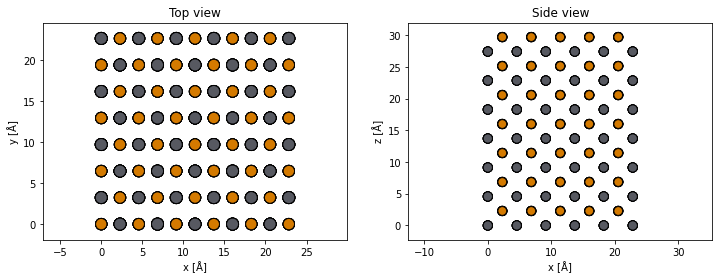

In [177]:
atoms = read('/Users/yukunl/Documents/Anaconda_starting folder/HAADF simulation/PbTe_110_25x25x30.xyz')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view');
#ax1.set_xlim(-1,60)
#ax2.set_ylim(-1,35)

In [178]:
# assign cell size a
atoms.cell[0,0] = 25
atoms.cell[1,1] = 25
atoms.cell[2,2] = 30

In [179]:
potential = Potential(atoms, 
                      gpts=1200,
                      projection='finite', 
                      slice_thickness=2, 
                      parametrization='kirkland')

potential = potential.build()

In [ ]:
plt.matshow(potential.array.mean(0)**0.65)

In [10]:
# sigmas = {'Pb': 0.1, 'Te': 0.1, 'Sn': 0.1, 'Ge': 0.1, 'Cd': 0.1} # standard deviations of thermal vibrations
# num_configs = 16 # number of frozen phonon configurations

# frozen_phonons = FrozenPhonons(atoms, num_configs=num_configs, sigmas=sigmas)
# potential = Potential(frozen_phonons, gpts=1200, slice_thickness=5, parametrization='kirkland', projection='finite')
# potential = potential.build()

In [ ]:
probe = Probe(energy=200e3, semiangle_cutoff=27.5, rolloff=0.1, defocus=40, Cs=3e5, focal_spread=40)
gridscan = GridScan(start=[0, 0], end=[20, 20], sampling=probe.ctf.nyquist_sampling * 0.5)

detector = [PixelatedDetector(max_angle='valid', resample='uniform')]
measurement = probe.scan(gridscan, detector, potential)

measurement.write('PbTe_3nm_1200gpts_3nmxy_0.7Nyquist_Cs1e6_focalspread40_nophonons.h5')

In [ ]:
measurement.write('HEA_disorder_3nm_1200gpts_3nmxy_0.9Nyquist_Cs1e6_focalspread40_nophonons.h5')

### Read measurement

In [182]:
measurement = abtem.Measurement.read('/Users/yukunl/Documents/Anaconda_starting folder/HAADF simulation/PbTe_3nm_1200gpts_2nmxy_0.9Nyquist_Cs1e6_focalspread40_nophonons.h5')




In [5]:
#measurement_test.array.shape

## Manual mask

In [183]:
data = measurement.array
avgDP = data.mean(axis=(0, 1))

In [184]:
x, y = np.indices((avgDP.shape[0], avgDP.shape[1]))
#mask_BF = (x - ic) ** 2 + (y-jc) ** 2 < 4 ** 2
ic = avgDP.shape[0]//2
jc = avgDP.shape[1]//2

#create DF mask
mask1 = (x - ic) ** 2 + (y-jc) ** 2 > 90 ** 2 #inner diameter 
mask2 = (x - ic) ** 2 + (y-jc) ** 2 < 370 ** 2 #outer diameter 
mask_DF=np.logical_and(mask1, mask2) #use logical to create annular detector

#DF  =(np.sum(data*(mask_DF), axis=(2,3)))

#plt.imshow(DF)  

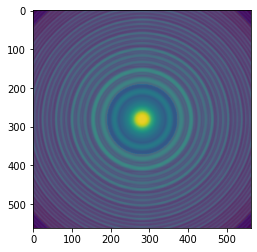

In [185]:
plt.imshow(avgDP**0.1)
plt.imshow(mask_DF,alpha=0.1)

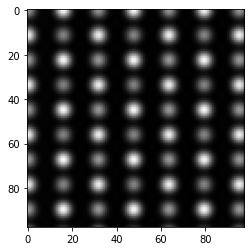

In [186]:
x, y = np.indices((avgDP.shape[0], avgDP.shape[1]))
ic = avgDP.shape[0]//2
jc = avgDP.shape[1]//2
#mask_BF = (x - ic) ** 2 + (y-jc) ** 2 < 4 ** 2


#create DF mask
mask1 = (x - ic) ** 2 + (y-jc) ** 2 > 68 ** 2 #inner diameter    #110 - 350
mask2 = (x - ic) ** 2 + (y-jc) ** 2 < 280 ** 2 #outer diameter 
mask_DF=np.logical_and(mask1, mask2) #use logical to create annular detector

DF  =(np.sum(data*(mask_DF), axis=(2,3)))

plt.imshow(DF, cmap='gray')      
#plt.axis('off')
#plt.savefig('/Users/yukunl/Desktop/OneDrive/OneDrive - Northwestern University/Experimental Data/HEA/Manuscripts/Figures/Figure RT TEM/Simulation/HEA/Simulation/test.tiff')


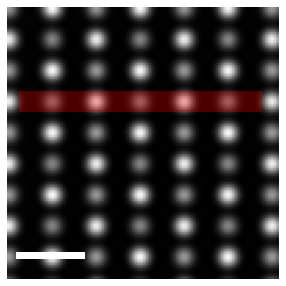

In [200]:
start = (33.5,7.5)
end = (33.5,87.5)

fig, ax = plt.subplots(figsize=(5,5))


ax.imshow(DF, cmap='gray') 
ax.plot([start[1], end[1]], [start[0], end[0]], 'r', linewidth=21,alpha=0.3)

size_pixel = 5/measurement.calibrations[0].sampling;
size_real = ''

scalebar = AnchoredSizeBar(ax.transData,
                           size_pixel, size_real, 'lower left', 
                           pad=0.8,
                           color='white',
                           frameon=False,
                           size_vertical=2)

ax.add_artist(scalebar)


plt.axis('off')
plt.savefig('/Users/yukunl/Desktop/OneDrive/OneDrive - Northwestern University/Experimental Data/HEA/Manuscripts/Figures/Figure RT TEM/Simulation/Simulation/Simulation/PbTe_Simulation.tiff',dpi=300,bbox_inches='tight', pad_inches=0)

Text(0, 0.5, 'Intensity (a.u.)')

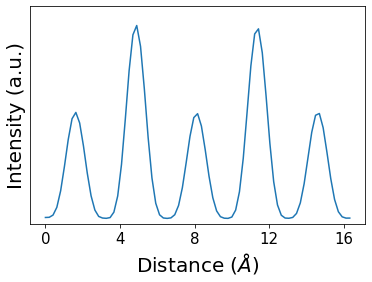

In [154]:
size_pixel = measurement.calibrations[0].sampling
y_intensity = skimage.measure.profile_line(DF, start, end, mode='constant',linewidth=1) # intensity
x_length = np.linspace(0,y_intensity.shape[0]-1,num=y_intensity.shape[0])*size_pixel
plt.plot(x_length, y_intensity)

plt.ylim([0.01,0.13])
plt.xticks(np.arange(0, 18, 4),fontsize=15)
plt.yticks([])
plt.xlabel('Distance (${\AA}$)', fontsize=20)
plt.ylabel('Intensity (a.u.)', fontsize=20)

In [157]:
np.savetxt('intensity_PbTe.csv', y_intensity, delimiter=',')
np.savetxt('xlength_PbTe.csv', x_length, delimiter=',')

### HEA

In [190]:
measurement_HEA = abtem.Measurement.read('/Users/yukunl/Documents/Anaconda_starting folder/HAADF simulation/HEA_disorder_3nm_1200gpts_2nmxy_0.9Nyquist_Cs1e6_focalspread40_nophonons.h5')
data_HEA = measurement_HEA.array
avgDP_HEA = data_HEA.mean(axis=(0, 1))



In [191]:
x, y = np.indices((avgDP_HEA.shape[0], avgDP_HEA.shape[1]))
#mask_BF = (x - ic) ** 2 + (y-jc) ** 2 < 4 ** 2
ic = avgDP_HEA.shape[0]//2
jc = avgDP_HEA.shape[1]//2

#create DF mask
mask1_HEA = (x - ic) ** 2 + (y-jc) ** 2 > 68 ** 2 #inner diameter 
mask2_HEA = (x - ic) ** 2 + (y-jc) ** 2 < 280 ** 2 #outer diameter 
mask_DF_HEA=np.logical_and(mask1_HEA, mask2_HEA) #use logical to create annular detector

#DF  =(np.sum(data*(mask_DF), axis=(2,3)))

#plt.imshow(DF)  

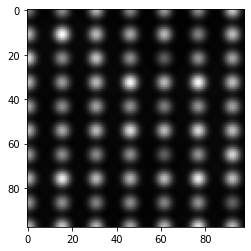

In [192]:
DF_HEA  =(np.sum(data_HEA*(mask_DF_HEA), axis=(2,3)))

plt.imshow(DF_HEA, cmap='gray')      

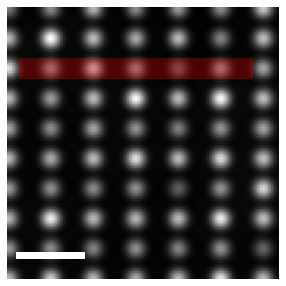

In [199]:
start = (21.5,7.5)
end = (21.5,84)

fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(DF_HEA, cmap='gray') 
ax.plot([start[1], end[1]], [start[0], end[0]], 'r', linewidth=21,alpha=0.3)
size_pixel = 5/measurement_HEA.calibrations[0].sampling;
size_real = ''

scalebar = AnchoredSizeBar(ax.transData,
                           size_pixel, size_real, 'lower left', 
                           pad=0.8,
                           color='white',
                           frameon=False,
                           size_vertical=2)

ax.add_artist(scalebar)


plt.axis('off')
plt.savefig('/Users/yukunl/Desktop/OneDrive/OneDrive - Northwestern University/Experimental Data/HEA/Manuscripts/Figures/Figure RT TEM/Simulation/Simulation/Simulation/HEA_Simulation.tiff',dpi=300,bbox_inches='tight', pad_inches=0)

(0.01, 0.13)

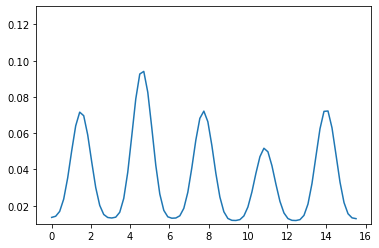

In [159]:
size_pixel = measurement_HEA.calibrations[0].sampling
y_intensity = skimage.measure.profile_line(DF_HEA, start, end, mode='constant',linewidth=1) # intensity
x_length = np.linspace(0,y_intensity.shape[0]-1,num=y_intensity.shape[0])*size_pixel

coeff = 0.07161747/0.05379538
plt.plot(x_length, y_intensity*coeff)
plt.ylim([0.01,0.13])

In [160]:
np.savetxt('intensity_HEA.csv', y_intensity, delimiter=',')
np.savetxt('xlength_HEA.csv', x_length, delimiter=',')